# Машинное обучение, DS-поток
## Домашнее задание 3A

**Правила:**

* Дедлайн **09 марта 23:59**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить на почту ` mipt.stats@yandex.ru`, указав тему письма `"[ml] Фамилия Имя - задание 3A"`. Квадратные скобки обязательны. Если письмо дошло, придет ответ от автоответчика.
* Прислать нужно ноутбук и его pdf-версию (без архивов). Названия файлов должны быть такими: `3A.N.ipynb` и `3A.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Задание стоит 15 баллов.**

In [262]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set(font_scale=1.6)
plt.rcParams['axes.facecolor'] = 'lightgrey'

Вспомним, как именно происходит построение решающего дерева. Для построения дерева в каждой нелистовой вершине происходит разбиение подвыборки на две части по некоторому признаку $x_j$. Этот признак и порог $t$, по которому будет происходить разбиение, мы хотим брать не произвольно, а основываясь на соображениях оптимальности.  Для этого нам необходимо знать некоторый фукционал качества, который будем оптимизировать при построении разбиения. 

Обозначим через $X_m$ -- множество объектов, попавших в вершину $m$, разбиваемую на данном шаге, а через $X_l$ и $X_r$ -- объекты, попадающие в левое и правое поддерево соответственно при заданном правиле $I\{x_j < t\}$. Пусть также $H$ -- используемый критерий информативности (impurity criterion).

Выпишите функционал, который необходимо минимизировать при разбиении вершины:

**Ответ:** 
$$
Q(X_m, j, t) = \frac{|X_l|}{|X_m|} H(X_l) + \frac{|X_r|}{|X_m|} H(X_r)
$$

**Реализация критериев информативности.**


Вспомните еще раз, на какой общей идее основаны критерии информативности и какую характеристику выборки они стремятся оптимизировать?

**Ответ:** критерии информативности показывают разброс ответов в вершине, чем меньше разброс, тем меньше значение критерий. Они стремятся оптимизировать то, насколько хорошо подвыборка, попавшая в вершину, предсказывается константой.


Перед тем, как непосредственно работать с решающими деревьями, реализуйте функции подсчёта значения критериев разбиения вершин решающих деревьев. Использовать готовые реализации критериев или классов для решающих деревьев из `sklearn` и из других библиотек **запрещено.** Также при реализации критериев по причине неэффективности **запрещается использовать циклы**. Воспользуйтесь библиотекой `numpy`.

Каждая функция принимает на вход одномерный `numpy`-массив размерности `(n,)` из значений отклика.

In [263]:
# Код функций, реализующих критерии разбиения. 

def mean_square_criterion(y):
    ''' Критерий для квадратичной функции потерь. '''
    
    return np.mean((y - y.mean())**2)


def mean_abs_criterion(y):
    ''' Критерий для абсолютной функции потерь. '''
    
    return np.mean(np.abs(y - y.mean()))


def get_probs_by_y(y):
    ''' Возвращает вектор частот для каждого класса выборки. '''

    return np.unique(y, return_counts=True)[1] / len(y)


def gini_criterion(y):
    ''' Критерий Джини. '''
    
    probs = get_probs_by_y(y)
    return np.sum(probs * (1 - probs))


def entropy_criterion(y):
    ''' Энтропийный критерий. '''
    probs = get_probs_by_y(y)
    return - np.sum(probs * np.log(probs))

Протестируйте реализованные функции.

Тесты для распределения вероятностей на классах.

In [264]:
assert np.allclose(get_probs_by_y([1, 1, 2, 2, 7]), np.array([0.4, 0.4, 0.2]))
assert np.allclose(get_probs_by_y([1]), np.array([1]))

Тесты для критериев разбиения.

Ниже подавались не numpy-массивы, переделал под numpy.

In [265]:
assert np.allclose(entropy_criterion([25]), 0)
assert np.allclose(gini_criterion([25]), 0)
assert np.allclose(mean_square_criterion(np.array([10, 10, 10])), 0)
assert np.allclose(mean_abs_criterion(np.array([10, 10, 10])), 0)

**Реализация класса решающего дерева.**

Для того, чтобы лучше понять, как устроены решающие деревья и как именно устроен процесс их построения, вам предлагается реализавать класс `BaseDecisionTree`, реализующий базовые функции решающего дерева.  Большая часть кода уже написана. 

Используются следующие классы:

**Класс** `BaseDecisionTree` - класс для решающего дерева, в котором реализовано построение дерева. Все вершины дерева хранятся в списке `self.nodes`, при этом вершина с номером 0 - корень.


1) `__init__` - инициализация дерева. Здесь сохраняются гиперпараметры дерева: `criterion`, `max_depth`, `min_samples_split` и инициализируется список вершин, состоящий только из одной вершины - корневой,

2) `build_` - рекурсивная функция построения дерева. В ней при посещении каждой вершины дерева проверяются условия, стоит ли продолжать разбивать эту вершину. Если да, то перебираются все возможные признаки и пороговые значения и выбирается та пара (признак, значение), которой соответствует наименьшее значение критерия информативности,

3) `fit` - функция обучения дерева, принимающая на вход обучающую выборку. В этой функции происходит предподсчёт всех возможных пороговых значений для каждого из признаков, а затем вызывается функция `build_`.

**Класс** `Node` - класс вершины дерева. Внутри вершины, помимо раздяляющего признака и порога хранятся `self.left_son`, `self.right_son` - номера дочерних вершин, а также `self.left_prob` и `self.right_prob` - вероятности попадания элемента в каждую из них. При этом в листовых вершиных хранятся также `self.y_values` - значения соответствующих элементов выборки, попавших в вершину.

1) `__init__` - инициализация вершины. Принимает в качестве аргументов разделяющий признак и пороговое значение и сохраняет их.

**Класс** `DecisionTreeRegressor` - наследник класса `BaseDecisionTree`, в котором реализованы функции для предсказаний при решении задачи регрессии.

1) `predict_instance` - получение предсказания для одного элемента выборки. Выполняется посредством спуска по решающему дереву до листовой вершины,

2) `predict` - получение предсказаний для всех элементов выборки.


**Класс** `DecisionTreeClassifier` - наследник класса `BaseDecisionTree`, в котором реализованы функции для предсказаний при решении задачи классификации.

1) `predict_proba_instance` - предсказание распределения вероятностей по классам для одного элемента выборки, 

2) `predict_proba` - предсказание распределения вероятностей по классам для всех элементов выборки,

3) `predict_proba` - предсказание меток классов для всех элементов выборки.

Перед написанием кода разбиения дерева, ответьте на вопрос, какие пороговые значения для каждого из признаков вы будете перебирать. Почему рассматривать другие значения в качестве пороговых не имеет смысла?

**Ответ:** для каждого признака перебираем только сами значения признака, т.к. подобный перебор покрывает все возможные разбиения на train выборке, а про test/validate мы ничего не знаем, поэтому менять перебираемые значения признаков нет смысла.

**Структура решающего дерева**

<img src="https://sun1-84.userapi.com/VGHHeEihyIdwbnZMCDLMoIBXyIq_k3U77KJoFQ/fBDwbb5VHNQ.jpg"/>

In [266]:
def get_not_nans(arr):
    '''
    Функция, которая создаёт и возвращает новый массив 
    из всех элементов переданного массива, не являющихся None.
    '''
    
    return arr[np.invert(np.isnan(arr))]


class Node(object):
    def __init__(self, split_feature=None, split_threshold=None):
        '''
        Функция инициализации вершины решающего дерева.
        
        Параметры.
        1) split_feature - номер разделяющего признака
        2) split_threshold - пороговое значение
        '''
        
        self.split_feature = split_feature
        self.split_threshold = split_threshold
        # По умолчанию считаем, что у вершины нет дочерних вершин.
        self.left_son, self.right_son = None, None
        # Вероятности попадания в каждую из дочерних вершин нужно поддерживать 
        # для корректной обработки данных с пропусками
        self.left_prob, self.right_prob = 0, 0
        # Массив значений y. Определён только для листовых вершин дерева
        self.y_values = None
        

class BaseDecisionTree(BaseEstimator):
    '''
    Здесь содержится реализация всех основных функций для работы
    с решающим деревом.
    
    Наследование от класса BaseEstimator нужно для того, чтобы 
    в дальнейшем данный   класс можно было использовать в 
    различных функциях библиотеки sklearn, например, в функциях 
    для кросс-валидации.
    '''
    
    def __init__(self, criterion, max_depth=np.inf, min_samples_split=2):
        '''
        Функция инициализации решающего дерева.
        
        Параметры.
        1) criterion - критерий информативности, 
        2) max_depth - максимальная глубина дерева,
        3) min_samples_split - минимальное количество элементов 
        обучающей выборки,  которое должно попасть в вершину, 
        чтобы потом происходило разбиение этой вершины.
        '''
        
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        # Список всех вершин дерева. В самом начале 
        # работы алгоритма есть только одна 
        # вершина - корень.
        self.nodes = [Node()]
        # Количество классов. Актуально только 
        # при решении задачи классификации.
        self.class_count = 1
        # Сюда нужно будет записать все значения 
        # для каждого из признаков датасета.
        self.feature_values = None
    
    def build_(self, v, X, y, depth=0):
        '''
        Рекурсивная функция построения решающего дерева.
        
        Параметры.
        1) v - номер рассматриваемой вершины
        2) X, y - обучающая выборка, попавшая в текущую вершину
        3) depth - глубина вершины с номером v
        '''
        
        if depth == self.max_depth or len(y) < self.min_samples_split:
            # Еcли строим дерево для классификации, то 
            # сохраняем метки классов всех элементов выборки,
            # попавших в вершину.
            if callable(getattr(self, "set_class_count", None)):
                self.nodes[v].y_values = y.copy()
            # Для регрессии сразу вычислим среднее всех 
            # элементов вершины.
            else:
                self.nodes[v].y_values = np.mean(y)
            return
        
        best_criterion_value = np.inf
        best_feature, best_threshold = 0, 0
        sample_size, feature_count = X.shape
        
        # переберём все возможные признаки и значения порогов,
        # найдём оптимальный признак и значение порога 
        # и запишем их в best_feature, best_threshold
        for feature_id in range(feature_count):
            for threshold in self.feature_values[feature_id]:
                # Рассматриваем элементы, где признак не None
                
                X_full = X[np.invert(np.isnan(X[:, feature_id]))]
                y_full = y[np.invert(np.isnan(X[:, feature_id]))]
                
                y_left = y_full[X_full[:, feature_id] < threshold]
                y_right = y_full[X_full[:, feature_id] >= threshold]
                
                criterion_value = X_full.shape[0] / X.shape[0] * \
                                      self.criterion(y_left) * len(y_left) / len(y_full) + \
                                      self.criterion(y_right) * len(y_right) / len(y_full)

                if criterion_value < best_criterion_value:
                    best_criterion_value = criterion_value
                    best_feature = feature_id
                    best_threshold = threshold
                    
            
        # сохраним найденные параметры в класс текущей вершины
        self.nodes[v].split_feature = best_feature
        self.nodes[v].split_threshold = best_threshold
        
        # разделим выборку на 2 части по порогу
        
        empty_indices = np.isnan(X[:, best_feature])
        full_indices = np.invert(empty_indices)
        
        X_full = X[full_indices]
        y_full = y[full_indices]
        
        self.nodes[v].left_prob = (X_full[:, best_feature] < best_threshold).mean()
        self.nodes[v].right_prob = 1 - self.nodes[v].left_prob
        
        X_l = np.concatenate((X_full[X_full[:, best_feature] < best_threshold], X[empty_indices]))
        X_r = np.concatenate((X_full[X_full[:, best_feature] >= best_threshold], X[empty_indices]))
        y_l = np.concatenate((y_full[X_full[:, best_feature] < best_threshold], y[empty_indices]))
        y_r = np.concatenate((y_full[X_full[:, best_feature] >= best_threshold], y[empty_indices]))
        
        # создаём левую и правую дочерние вершины,
        # и кладём их в массив self.nodes 
        
        self.nodes.append(Node())
        self.nodes.append(Node())
        
        # сохраняем индексы созданных вершин в качестве 
        # левого и правого сына вершины v
        
        self.nodes[v].left_son, self.nodes[v].right_son =\
            len(self.nodes) - 2, len(self.nodes) - 1
        # рекурсивно строим дерево для дочерних вершин
        
        self.build_(self.nodes[v].left_son, X_l, y_l, depth+1)
        self.build_(self.nodes[v].right_son, X_r, y_r, depth+1)
    
    def fit(self, X, y):
        '''
        Функция, из которой запускается построение 
        решающего дерева по обучающей выборке.
        
        Параметры.
        X, y - обучающая выборка
        '''
        
        # сохраним заранее все пороги для каждого из 
        # признаков обучающей выборки
        X, y = np.array(X), np.array(y)
        self.feature_values = []
        for feature_id in range(X.shape[1]):
            self.feature_values.append(
                np.unique(get_not_nans(X[:, feature_id]))
            )
        set_class_count = getattr(self, "set_class_count", None)
        # если строится дерево для классификации, 
        # то нужно посчитать количество классов 
        if callable(set_class_count):
            set_class_count(y)
        self.build_(0, X, y)

Теперь, когда общий код решающего дерева написан, нужно сделать обёртки над `BaseDecisionTree` - классы `DecisionTreeRegressor` и `DecisionTreeClassifier` для использования решающего дерева в задачах регрессии и классификации соответственно.

Допишите функции `predict_instance` и `predict_proba_instance` в классах для регрессии и классификации соответственно. В этих функциях нужно для одного элемента $x$ выборки промоделировать спуск в решающем дереве, а затем по листовой вершине, в которой окажется объект, посчитать для классификации - распределение вероятностей, а для регрессии - число $y$.

In [267]:
class DecisionTreeRegressor(BaseDecisionTree):
    def predict_instance(self, x, v):
        '''
        Рекурсивная функция, предсказывающая значение
        y для одного элемента x из выборки.
        
        Параметры.
        1) x - элемент выборки, для которого
        требуется предсказать значение y
        2) v - рассматриваемая вершина дерева
        '''
        
        # если вершина - лист, возвращаем в качестве предсказания 
        # среднее всех элементов, содержащихся в ней
        if self.nodes[v].left_son == None:
            return self.nodes[v].y_values # т.к. в Base мы ровно его и записывали
            
        # если у объекта x значение признака по
        # которому происходит разделение,  меньше 
        # порогового, то спускаемся в левое поддерево,
        # иначе - в правое
        if x[self.nodes[v].split_feature] < self.nodes[v].split_threshold:
            return self.predict_instance(x, self.nodes[v].left_son)
        elif x[self.nodes[v].split_feature] >= self.nodes[v].split_threshold:
            return self.predict_instance(x, self.nodes[v].right_son)
        # а если у элемента отсутствует значение 
        # разделяющего признака,  то будем спускаться 
        # в оба поддерева
        else:
            left_predict = self.predict_instance(x, self.nodes[v].left_son)
            right_predict = self.predict_instance(x, self.nodes[v].right_son)
            return self.nodes[v].left_prob *  left_predict + self.nodes[v].right_prob * right_predict
    
    def predict(self, X):
        '''
        Функция, предсказывающая значение
        y для всех элементов выборки X.
        
        Параметры.
        X - выборка, для которой требуется
        получить вектор предсказаний y
        '''
        
        return [self.predict_instance(x, 0) for x in X]

Для удобства реализации функции `predict_proba_instance` класса `DecisionTreeClassifier` будем считать, что все классы имеют целочисленные метки от 0 до $k-1$, где $k$ - количество классов. Если бы это условие не было выполнено, то нужно было бы сначала сделать предобработку меток классов в датасете.

In [268]:
class DecisionTreeClassifier(BaseDecisionTree):
    def set_class_count(self, y):
        '''
        Функция, вычисляющая количество классов 
        в обучающей выборке.
        
        Параметры.
        y - значения класса в обучающей выборке
        '''
        
        self.class_count = np.max(y) + 1
    
    def predict_proba_instance(self, x, v):
        '''
        Рекурсивная функция, предсказывающая вектор
        вероятностей принадлежности  объекта x
        к классам
        
        Параметры.
        1) x - элемент выборки, для которого 
        требуется предсказать значение y
        2) v - вершина дерева, в которой 
        находится алгоритм
        '''
        
        if self.nodes[v].left_son == None:
            result = np.zeros(self.class_count)
            classes, counts = np.unique(
                self.nodes[v].y_values, return_counts=True)
            result[classes.astype(int)] = counts
            return result / np.sum(result)
            
        # если у объекта x значение признака по которому
        # происходит разделение, меньше порогового, 
        # то спускаемся в левое поддерево, иначе - в правое
        if x[self.nodes[v].split_feature] < self.nodes[v].split_threshold:
            return self.predict_proba_instance(x, self.nodes[v].left_son)
        elif x[self.nodes[v].split_feature] >= self.nodes[v].split_threshold:
            return self.predict_proba_instance(x, self.nodes[v].right_son)
        # а если у объекта отсутствует значение 
        # разделяющего признака, то будем спускаться 
        # в оба поддерева
        else:
            left_predict = self.predict_proba_instance(
                x, self.nodes[v].left_son)
            right_predict = self.predict_proba_instance(
                x, self.nodes[v].right_son)
            return self.nodes[v].left_prob *  left_predict + self.nodes[v].right_prob * right_predict
    
    def predict_proba(self, X):
        '''
        Функция, предсказывающая вектор вероятностей
        принадлежности объекта x к классам для 
        каждого x из X
        
        Параметры.
        X - выборка, для которой требуется получить вектор предсказаний y
        '''
        
        return [self.predict_proba_instance(x, 0) for x in X]
    
    def predict(self, X):
        '''
        Функция, предсказывающая метку класса для
        всех элементов выборки X.
        
        Параметры.
        X - выборка, для которой требуется получить
        вектор предсказаний y
        '''
        
        return np.argmax(self.predict_proba(X), axis=1)

**Подбор параметров.**

В этой части задания вам предлагается поработать с написанным решающим деревом, применив его к задачи классификации и регрессии, и в обеих задачах подобрать оптимальные параметры для построения.

Не забывайте писать выводы.

**1. Задача классификации.**

Теперь - самое время протестировать работу написанного нами решающего дерева. Делать мы это будем на датасете для классификации вина из `sklearn`.

In [241]:
from sklearn.datasets import load_wine

X, y = load_wine(return_X_y=True)

Далее для критерия Джини и энтропийного критерия найдем оптимальные параметры обучения дерева - `max_depth` и `min_samples_split`.

In [242]:
classification_criteria = [gini_criterion, entropy_criterion]
criterion_names = ['gini', 'entropy']

Сначала надо разбить выборку на train и test.

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

Теперь проведите кросс-валидацию для каждого из критериев разбиения вершин.

In [105]:
for criterion, criterion_name in zip(classification_criteria, criterion_names):
    tree_gridsearch = GridSearchCV(
        estimator=DecisionTreeClassifier(criterion),
        param_grid={'max_depth': np.arange(3, 8),
                    'min_samples_split': [1, 2, 5]},
        scoring='accuracy'
        )
    tree_gridsearch.fit(X_train, y_train)
    print(criterion_name + ' best params: ', tree_gridsearch.best_params_)
    accuracy = accuracy_score(tree_gridsearch.best_estimator_.predict(X_test), y_test)
    print('accuracy:', accuracy)
    assert(accuracy >= 0.85, "Something is wrong with your classifier")

gini best params:  {'max_depth': 3, 'min_samples_split': 1}
accuracy: 0.9444444444444444
entropy best params:  {'max_depth': 3, 'min_samples_split': 1}
accuracy: 0.9074074074074074


**Построение графиков.**

Постройте графики зависимости accuracy от максимальной глубины дерева на обучающей и тестовой выборке для каждого критерия на train и на test. В качестве максимальной глубины используйте значения от 3 до 7. Значение `min_samples_split` фиксируйте.

In [90]:
def get_train_and_test_accuracy(param_name, grid, criterion, min_samples_split=2):
    train_acc, test_acc = [], []
    for param_value in grid:
        estimator = DecisionTreeClassifier(**{param_name: param_value,
                                              'min_samples_split': min_samples_split,
                                              'criterion': criterion})
        estimator.fit(X_train, y_train)
        train_acc.append(accuracy_score(y_train, estimator.predict(X_train)))
        test_acc.append(accuracy_score(y_test, estimator.predict(X_test)))
    return train_acc, test_acc

def plot_dependence(param_name, criterion, grid=range(3, 8), title=''):
    plt.figure(figsize=(12, 6))
    train_acc, test_acc = get_train_and_test_accuracy(param_name, grid, criterion)
    plt.plot(grid, train_acc, label='train', lw=3)
    plt.plot(grid, test_acc, label='test', lw=3)
    plt.legend(fontsize=14)
    plt.xlabel(param_name)
    plt.ylabel('Аccuracy')
    plt.title(title, fontsize=20)
    plt.show()

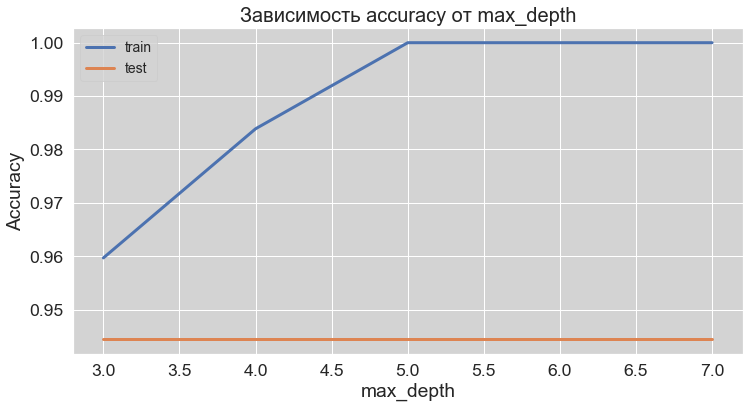

In [91]:
plot_dependence('max_depth', criterion=gini_criterion, title='Зависимость accuracy от max_depth')

Сделайте выводы. Почему графики получились такими? Как соотносятся оптимальные значения параметров на обучающей и на тестовой выборках?

**Вывод.**

Как видно из графика, оптимальный параметр глубины для train - $5$, там достигается 100% точность. При этом для test любой параметр глубины, начиная с 3, дает один и тот же результат.  
Заметим, что подобное поведение графиков свидетельствует о переобучении (т.к. train-acc растет, а на test не возрастает).  
Вполне возможно, что на глубине 3 уже достигается достаточно хорошее разбиение для классификации нашего датасета, а дальше разбираются частные случаи, некоторые из которых могли даже не попасть в train.

**2. Задача регрессии.**

Проделайте аналогичные шаги для задачи регрессии. В качестве датасете возьмите `boston` из `sklearn`, а в качестве критерия качества возьмите r2_score. Рассмотрим более широкий диапазон значений для `max_depth`: от 3 до 14.

In [93]:
from sklearn.datasets import load_boston

boston_X, boston_y = load_boston(return_X_y=True)

In [108]:
regression_criteria = [mean_square_criterion, mean_abs_criterion]
criterion_names = ['mse', 'mae']

Разобьём выборку на обучение и тест.

In [109]:
X_train, X_test, y_train, y_test = train_test_split(boston_X, boston_y, test_size=0.3, random_state=17)

Проведите эксперименты, аналогичны тем, что были сделаны для задачи классификации.

Определим оптимальные параметры

In [113]:
for criterion, criterion_name in zip(regression_criteria, criterion_names):
    tree_gridsearch = GridSearchCV(
        estimator=DecisionTreeRegressor(criterion),
        param_grid={'max_depth': np.arange(3, 14),
                    'min_samples_split': [1, 3]},
        scoring='r2'
        )
    tree_gridsearch.fit(X_train, y_train)
    print(criterion_name + ' best params: ', tree_gridsearch.best_params_)
    r2 = r2_score(tree_gridsearch.best_estimator_.predict(X_test), y_test)
    print('r2_score:', r2)

mse best params:  {'max_depth': 8, 'min_samples_split': 3}
r2_score: 0.8335309252229686
mae best params:  {'max_depth': 3, 'min_samples_split': 1}
r2_score: 0.7460036686149394


In [122]:
def get_train_and_test_r2(param_name, grid, criterion, min_samples_split=2):
    train_r2, test_r2 = [], []
    for param_value in grid:
        estimator = DecisionTreeRegressor(**{param_name: param_value,
                                              'min_samples_split': min_samples_split,
                                              'criterion': criterion})
        estimator.fit(X_train, y_train)
        train_r2.append(r2_score(y_train, estimator.predict(X_train)))
        test_r2.append(r2_score(y_test, estimator.predict(X_test)))
    return train_r2, test_r2

def plot_dependence_regr(param_name, criterion, grid=range(3, 14), title=''):
    plt.figure(figsize=(12, 6))
    train_r2, test_r2 = get_train_and_test_r2(param_name, grid, criterion)
    plt.plot(grid, train_r2, label='train', lw=3)
    plt.plot(grid, test_r2, label='test', lw=3)
    plt.legend(fontsize=14)
    plt.xlabel(param_name)
    plt.ylabel('r2_score')
    plt.title(title, fontsize=20)
    plt.show()

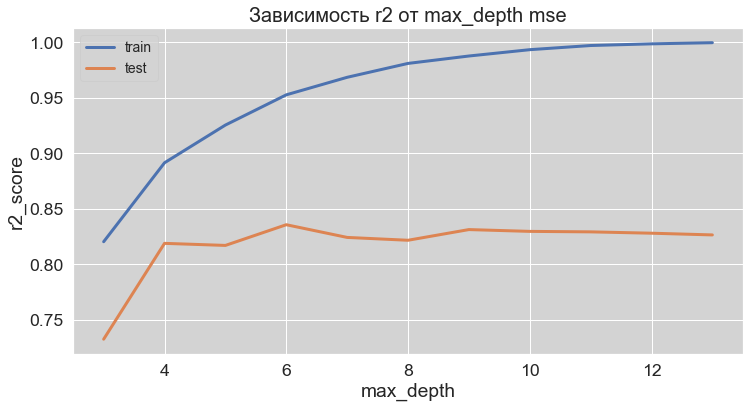

In [123]:
plot_dependence_regr('max_depth', criterion=mean_square_criterion, title='Зависимость r2 от max_depth mse')

Сделайте вывод, в котором объясните, почему графики получились такими.

Скорее всего, вы заметили, что дерево в этих экспериментах строится довольно медленно. Как можно ускорить его построение? Можно ли ускорить нахождение оптимального разбиения по некоторому вещественному признаку?

**Вывод.**

На этом графике уже можно заметить, что при глубине дерева больше 6, оно является переобученным, т.к. метрика на тесте начинает падать, а на трейне продолжает расти.  При глубине 12 у нас вообще идеально предсказывается.

Строилось дерево действительно долго, как можно ускорить построение?

Известны способы пересчета критериев за $O(1)$, которые можно реализовать - это достаточно сиильно ускорило бы. Так же можно дополнительно проверять однородность выборки в вершине, например, и в таком случае не делить.

### Обработка пропусков с использованием решающих деревьев.

А теперь рассмотрим датасет, в котором часть данных пропущена. В качестве примера возьмём датасет https://archive.ics.uci.edu/ml/datasets/Adult для определения категории дохода работников, по таким признакам, как возраст, образование, специальность, класс работы, пол, кол-во отрабатываемых часов в неделю и некоторым другим.

In [269]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education1', 'education2', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain',
    'capital-loss', 'hours-per-week', 'native-country', 'target'
]

Поскольку предсказание в дереве на данных с пропусками часто занимает сильно больше времени, чем в случае отсутствия пропусков (так как часто приходится спускаться разу в 2 поддерева), то для экономии времени сократим датасет, взяв из него только первые 10000 строк данных.

In [270]:
adult_df = pd.read_csv('adult.data', header=None)[:10000]
adult_df.columns = column_names
target = adult_df['target'] == ' >50K'
adult_df = adult_df.drop(['target'], axis=1)
adult_df.head()

age          workclass  fnlwgt  education1  education2  \
0   39          State-gov   77516   Bachelors          13   
1   50   Self-emp-not-inc   83311   Bachelors          13   
2   38            Private  215646     HS-grad           9   
3   53            Private  234721        11th           7   
4   28            Private  338409   Bachelors          13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  
0          2174             0              40   United-States  
1             0             0              13   United-States  
2             0             0              40   United-States  
3             0             0              40   United-States  
4             0             0              40            Cuba

Предобработаем датасет, заменив категориальные признаки one-hot векторами.

In [271]:
adult_df = pd.get_dummies(adult_df)
adult_df.head()

age  fnlwgt  education2  capital-gain  capital-loss  hours-per-week  \
0   39   77516          13          2174             0              40   
1   50   83311          13             0             0              13   
2   38  215646           9             0             0              40   
3   53  234721           7             0             0              40   
4   28  338409          13             0             0              40   

   workclass_ ?  workclass_ Federal-gov  workclass_ Local-gov  \
0             0                       0                     0   
1             0                       0                     0   
2             0                       0                     0   
3             0                       0                     0   
4             0                       0                     0   

   workclass_ Never-worked  ...  native-country_ Portugal  \
0                        0  ...                         0   
1                        0  ...                         0   
2                        0  ...                         0   
3                        0  ...                         0   
4                        0  ...                         0   

   native-country_ Puerto-Rico  native-country_ Scotland  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   

   native-country_ South  native-country_ Taiwan  native-country_ Thailand  \
0                      0                       0                         0   
1                      0                       0                         0   
2                      0                       0                         0   
3                      0                       0                         0   
4                      0                       0                         0   

   native-country_ Trinadad&Tobago  native-country_ United-States  \
0                                0                              1   
1                                0                              1   
2                                0                              1   
3                                0                              1   
4                                0                              0   

   native-country_ Vietnam  native-country_ Yugoslavia  
0                        0                           0  
1                        0                           0  
2                        0                           0  
3                        0                           0  
4                        0                           0  

[5 rows x 107 columns]

Поскольку все пропущенные значения относились к категориальным признакам и помечались в датасете знаком `?`, то для каждого категориального признака `feature` исходного датасета надо выполнить следующую процедуру: рассмотреть признак `feature_?` нового датасета и для всех строк, для которых выполнено `feature_?=1`, значениях всех признаков с префиксом `feature` установить в `None`. 

In [272]:
all_indices = np.arange(adult_df.shape[0])

for feature in column_names:
    if f'{feature}_ ?' in adult_df.columns:
        none_indices = all_indices[adult_df[f'{feature}_ ?'] == 1]
        
        for dummy_feature in adult_df.columns:
            if not dummy_feature.startswith(f'{feature}_ '):
                continue
            if dummy_feature != f'{feature}_ ?':
                adult_df[dummy_feature][none_indices] = None
        adult_df = adult_df.drop(f'{feature}_ ?', axis=1)

Посмотрим на распределение пропущенных значений по признакам.

In [273]:
np.sum(adult_df.isnull(), axis=0)

age                                  0
fnlwgt                               0
education2                           0
capital-gain                         0
capital-loss                         0
                                  ... 
native-country_ Thailand           181
native-country_ Trinadad&Tobago    181
native-country_ United-States      181
native-country_ Vietnam            181
native-country_ Yugoslavia         181
Length: 104, dtype: int64

Разобьём данные на обучающую и тестовую выборки в отношении 3:1.

In [274]:
X_adult_train, X_adult_test, y_adult_train, y_adult_test = train_test_split(
    adult_df, target, random_state=777
)

При помощи кросс-валидации найдём оптимальные гиперпараметры для каждого из критериев разбиения деревьев для классификации.

In [275]:
classification_criteria = [gini_criterion, entropy_criterion]
criterion_names = ['gini', 'entropy']

In [276]:
for criterion, criterion_name in zip(classification_criteria, criterion_names):
    tree_gridsearch = GridSearchCV(
        estimator=DecisionTreeClassifier(criterion),
        param_grid={'max_depth': np.array([2, 3, 5]),
                    'min_samples_split': [2, 5]},
        scoring='accuracy',
        verbose=10,
        n_jobs=-1
        )
    tree_gridsearch.fit(X_adult_train.values, y_adult_train.values)
    print(criterion_name + ' best params: ', tree_gridsearch.best_params_)
    acc = accuracy_score(tree_gridsearch.best_estimator_.predict(X_adult_test.values), y_adult_test.values)
    print('accuracy_score:', acc)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 10.8min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.7min finished


gini best params:  {'max_depth': 5, 'min_samples_split': 5}
accuracy_score: 0.8488
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 10.5min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.2min finished


entropy best params:  {'max_depth': 3, 'min_samples_split': 2}
accuracy_score: 0.8476


Проведите эксперименты c построением графиков, аналогичные тем, что были сделаны в предыдущем пункте для задач классификации и регрессии.

In [259]:
def get_train_and_test_acc(param_name, grid, criterion, min_samples_split=2):
    train_acc, test_acc = [], []
    for param_value in grid:
        estimator = DecisionTreeClassifier(**{param_name: param_value,
                                              'min_samples_split': min_samples_split,
                                              'criterion': criterion})
        estimator.fit(X_adult_train.values, y_adult_train.values)
        train_acc.append(accuracy_score(y_adult_train.values, estimator.predict(X_adult_train.values)))
        test_acc.append(accuracy_score(y_adult_test.values, estimator.predict(X_adult_test.values)))
        print('depth = {}'.format(str(param_value)) + ' finished')
    return train_acc, test_acc

def plot_dependence_clas(param_name, criterion, grid=range(1, 7), title=''):
    plt.figure(figsize=(12, 6))
    train_acc, test_acc = get_train_and_test_acc(param_name, grid, criterion)
    plt.plot(grid, train_acc, label='train', lw=3)
    plt.plot(grid, test_acc, label='test', lw=3)
    plt.legend(fontsize=14)
    plt.xlabel(param_name)
    plt.ylabel('accuracy')
    plt.title(title, fontsize=20)
    plt.show()

depth = 1 finished
depth = 2 finished
depth = 3 finished
depth = 4 finished
depth = 5 finished
depth = 6 finished


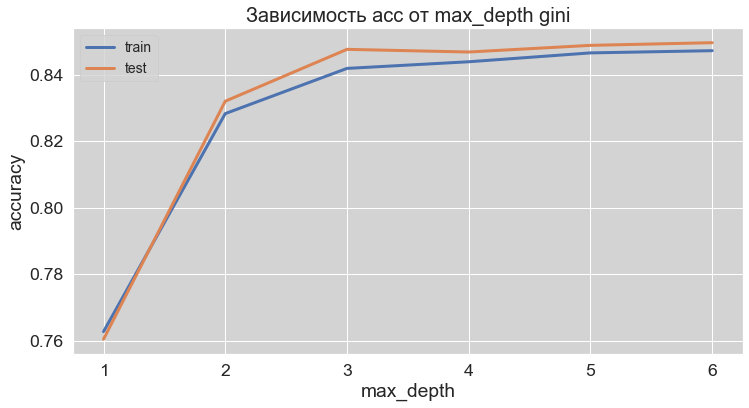

In [260]:
plot_dependence_clas('max_depth', criterion=gini_criterion, title='Зависимость acc от max_depth gini')

In [235]:
np.sum(y_adult_train) / len(y_adult_train)

0.23733333333333334

In [230]:
np.sum(y_adult_test) / len(y_adult_test)

0.2396

**Вывод.**
С неправильной функцией:  
Можно заметить странное поведение - вне зависимости от глубины, accuracy получается одинаковым как на тесте, так и на трейне. 

С помощью двух ячеек выше можно понять, что мое дерево обучилось так, что всегда предсказывает нулевой класс.  

Т.е. nan поспоспоствовали переобучению дерева под наиболее преобладающий класс.  

Это произошло из-за некорректной функции в начали base tree (в признаки попадают nan)  

С правильной функцией:  
Время 23:52, пытаюсь перезапустить код и успеть отрисовать хотя бы графики до дедлайна, исправил ту функцию.  
Успел заметить, что графики ведут адекватно, можно заметить переобучение при depth больше 5. Но из-за большого объема датасеа точности почти одинаковые - прекрасно.